# Attention


* Attention is a set operator that learns to reason about the structure of a set of elements.
* There are three inouts with every function. Query, Key, and Values.

Keys and Values are the same. Just fed differently.
key and valye can be onsidered as a db primary keys and value. So it will look for the closest key and return the value.

Query will measure the distance to all the keys, by using Cosine Similarity, normalize by the length of the vector, exponentiate and normalize. ALso known as softmax operator.

Softmax between input single queries and distance to all its keys. We get a set of weights from this which are alwayts pos and sum to 1. We compute weighted average of all values. If the value is high it has high weight and if it is low it has no relation.

Attention is a matrix operator. Set of M queries, compute dist with all Q and all K. Norm, compute softmax() and then retrieve weighted average using outout of softmax as weights.

Values and Keys are Matrxi with number of element x channels. Query is also matrix. Outout is also matrix with M elements and C which is dimensionalityh of outoput also channels.

For language taks, we take input and split into parts - characters, words, tokens. Tokens is the most popular.

Then we embed each part/token, embed will associate some feature vector to each token. Feed embeddings to attention.

Make Q, K, and V all equal to embeddings.

Take a sentence, convert to bunch of numbers, feed through layers to make sense of these numbers.

Two types of Attention. Self-Attention and Cross-Attention
self uses Q, K, and V.

corss-attention uses two inputs. Keys and Valyes come from same input but queries come from another set of inputs.

Self is used in NLP, and Cross is used in Vision.

# Multi-head Attention

Basic attentino is never used. MHA is almost always what people talk about.
issue wih self attention that cosine similarity diagonal of this will always be dominant. Meaning x1 will always be closest to itself x1.

To fix this we multiply it with linear layer before we feeed it into attention. so we input Wq, Wk, Wv. Weights x input.

multi head attention is simply multiple attention blocks connnected.

for example - takes an input x, runs multipke attneiton heads in parallel where each has its own weight matrix/linear layer, run them all through network and concat. and add one more linear layer for classification


In [ ]:
import torch

In [ ]:
torch_attn = torch.nn.MultiheadAttention(embed_dim=16, num_heads=4, dropout=0, batch_first=True) # first dim is our batch size.

In [ ]:
k,v,q = torch.rand(10,3,16), torch.rand(10,3,16), torch.rand(10,5,16)
o,_ = torch_attn(q,k,v)
print(o.shape) # batch size, number of queries, embed_dim
print([(n,v.shape) for n,v in torch_attn.named_parameters()])

torch.Size([10, 5, 16])
[('in_proj_weight', torch.Size([48, 16])), ('in_proj_bias', torch.Size([48])), ('out_proj.weight', torch.Size([16, 16])), ('out_proj.bias', torch.Size([16]))]


In [ ]:
class MHA(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.in_proj_keys = torch.nn.Linear(embed_dim, embed_dim)
        self.in_proj_values = torch.nn.Linear(embed_dim, embed_dim)
        self.in_proj_queries = torch.nn.Linear(embed_dim, embed_dim)
        self.out_proj = torch.nn.Linear(embed_dim, embed_dim)
        self.n_heads = num_heads

    def forward(self, q,k,v):
      from einops import rearrange
      p_q, p_k, p_v = self.in_proj_queries(q), self.in_proj_keys(k), self.in_proj_values(v)
      r_q = rearrange(p_q, 'b m (h d) -> b h m d', h=self.n_heads)
      r_k = rearrange(p_k, 'b n (h d) -> b h n d', h=self.n_heads)
      r_v = rearrange(p_v, 'b n (h d) -> b h n d', h=self.n_heads)

      scores  = torch.einsum('b h m d, b h n d -> b h m n', r_q, r_k) # vector product of every combination of b an h, m and n, and d. Rw attention weights.
      attn = torch.nn.functional.softmax(scores, dim=-1)

      result = torch.einsum('b h m n, b h n d -> b h m d', attn, r_v)
      result = rearrange(result, 'b h m d -> b m (h d)') # take the heads, group all heads and output along 1 dim. then return out_proj of result.
      return self.out_proj(result)

our_attn = MHA(16,4)
o = our_attn(q,k,v)
o1,_ = torch_attn(q,k,v)
print(o.shape, o1.shape)


torch.Size([10, 5, 16]) torch.Size([10, 5, 16])


# Positional Embeddings

Attention itself with weights is actually permutation invariant. what this means is shuffling keys and values give the same output.

this is a problem because it means we cannot reason about different structures. like if you move around words in a sentence they change meaning. what this code so far is not optimized to handle.

this is fine in problems like weather forecasting.

Add positiona to embeddings.

option 1: absolute positional embedding. use the absolute raw position. not meaningful, model will have hard time decoding position 1, 2, etc.

option 2: Sinusoidal positoinal embeddings. Sin and Cosine positional embedding. take input and location of input. divided it by some base frequency (power of 2). model can use this sin and cosine to loacte inputs.

option 3: learned positional embeddings. run them through a model and learn. performance drops when sequence length varies between train/test. train should be as long or longer than test.

Vision transformers, option 3 example.

option 4: relative positional embeddings.learn bias insdie the softmax. get rid of hald values.

Rotational Positonal Embeddings: built on absolute positoins. emeb abs pos, once computed it will resolve to weighted

Applications of PE: LLMs,Vision transformer, implicit functions.

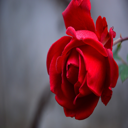

In [ ]:
import torch
import numpy as np
from PIL import Image
im = Image.open('/content/rose-3802424_1280.jpg')
im_small  = im.resize((128,128))
im_small



In [ ]:
class PositionalEmbedding(torch.nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.freq = torch.exp(-torch.arange(0, embed_dim, 2).float() / 2)

  def forward(self, x):
    x = x[...,None,:]*self.freq[...,None]
    #print(x.shape)
    return torch.cat([torch.sin(x), torch.cos(x)], dim=-1).view(*x.shape[:-2],-1)

pe = PositionalEmbedding(16)
pe(torch.tensor([[1,0],[0,1]])).shape

torch.Size([2, 32])

tensor(0.1701, grad_fn=<MeanBackward0>)
tensor(0.1424, grad_fn=<MeanBackward0>)
tensor(0.1321, grad_fn=<MeanBackward0>)
tensor(0.1201, grad_fn=<MeanBackward0>)
tensor(0.1066, grad_fn=<MeanBackward0>)
tensor(0.0932, grad_fn=<MeanBackward0>)
tensor(0.0863, grad_fn=<MeanBackward0>)
tensor(0.0802, grad_fn=<MeanBackward0>)
tensor(0.0763, grad_fn=<MeanBackward0>)
tensor(0.0778, grad_fn=<MeanBackward0>)
tensor(0.0760, grad_fn=<MeanBackward0>)
tensor(0.0716, grad_fn=<MeanBackward0>)
tensor(0.0698, grad_fn=<MeanBackward0>)
tensor(0.0679, grad_fn=<MeanBackward0>)
tensor(0.0668, grad_fn=<MeanBackward0>)
tensor(0.0655, grad_fn=<MeanBackward0>)
tensor(0.0657, grad_fn=<MeanBackward0>)
tensor(0.0651, grad_fn=<MeanBackward0>)
tensor(0.0625, grad_fn=<MeanBackward0>)
tensor(0.0630, grad_fn=<MeanBackward0>)
tensor(0.0618, grad_fn=<MeanBackward0>)
tensor(0.0603, grad_fn=<MeanBackward0>)
tensor(0.0600, grad_fn=<MeanBackward0>)
tensor(0.0612, grad_fn=<MeanBackward0>)
tensor(0.0582, grad_fn=<MeanBackward0>)


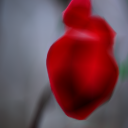

In [ ]:
class Rose(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.enc = PositionalEmbedding(12)
    self.net  = torch.nn.Sequential(
        torch.nn.Linear(24,256),
        torch.nn.ReLU(),
        torch.nn.Linear(256,128),
        torch.nn.ReLU(),
        torch.nn.Linear(128,64),
        torch.nn.ReLU(),
        torch.nn.Linear(64,3),
    )
  def forward(self,x):
    return self.net(self.enc(x))

rose_tensor = torch.as_tensor(np.array(im_small), dtype=torch.float32)/255.-0.5
postion  = torch.stack(torch.meshgrid(torch.linspace(-1,1,128), # x y cordinates from -1 1 of size 128,128
                                      torch.linspace(-1,1,128)),dim=-1)

net = Rose()


optim = torch.optim.Adam(net.parameters(), lr=0.001)
for it in range(5000):
  optim.zero_grad()
  loss = abs(net(postion) -rose_tensor).mean()
  if it%10==0:
    print(loss)
  loss.backward()
  optim.step()

Image.fromarray(((net(postion)+0.5).clamp(0,1)*255).cpu().to(torch.uint8).numpy())

# model cannoy find fine details but learns the background. because we used identity for encoder.



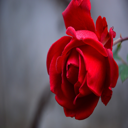

In [ ]:
im_small

# Transformer Architecture

In [ ]:
Transformer architecture is Multi-Head Attention + Multi layer perceptron (linear, relu, linear, norms, and res net)


In [ ]:
import torch

In [ ]:
class TransformerBlock(torch.nn.Module):
  def __init__(self, embed_dim, n_heads):
    super().__init__()
    self.self_attn = torch.nn.MultiheadAttention(embed_dim, n_heads, batch_first=True)
    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(embed_dim, embed_dim*4),
        torch.nn.ReLU(),
        torch.nn.Linear(embed_dim*4, embed_dim),
    )

    self.in_norm  = torch.nn.LayerNorm(embed_dim)
    self.mlp_norm = torch.nn.LayerNorm(embed_dim)

  def forward(self, x):
    x_norm = self.in_norm(x)
    x = x + self.self_attn(x_norm, x_norm, x_norm)[0] # the x + is the residual connection, basocally addind identity X
    x = x + self.mlp(self.mlp_norm(x)) # this is vanilla transformer layer.
    return x

class Transformer(torch.nn.Module):
  def __init__(self, embed_dim, n_heads, n_layers):
    super().__init__()
    self.net = torch.nn.Sequential(
        *[
            TransformerBlock(embed_dim, n_heads) for _ in range(n_layers)
        ]
        )

  def forward(self, x):
    return self.net(x)

net = Transformer(128,8,4)
x = torch.rand(16,10,128) # Same Dimension goes in and smae dim comes out. All that happens is it goes through a bunch of transformer layers.
print(net(x).shape)



torch.Size([16, 10, 128])
